# **IMPORTING LIBRARIES**

In [13]:
import pandas as pd
import numpy as np
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from scipy.stats import t, norm

# SCRAPING DATA

In [4]:
def scrap_table(url,headers):
  response = requests.get(url, headers=headers)
  if response.status_code == 200:

    soup = BeautifulSoup(response.text, 'html.parser')
    target_class = "ink-900"
    links = soup.find('a', class_=target_class)
    url2=url+links.get('href')
    response2 = requests.get(url2, headers=headers)
    soup2 = BeautifulSoup(response2.text, 'html.parser')
    data=[]


    table = soup.find('table')
    if table:
      rows = table.find_all('tr')
      headers = [th.text.strip() for th in rows[0].find_all('th')]

      for row in rows[1:]:
        cols = [td.text.strip() for td in row.find_all('td')]
        data.append(cols)

    else:
      print("Table not found on the page.")

    table2 = soup2.find('table')
    if table2:
      rows = table2.find_all('tr')

      headers = [th.text.strip() for th in rows[0].find_all('th')]

      for row in rows[1:]:
        cols = [td.text.strip() for td in row.find_all('td')]
        data.append(cols)

    else:
      print("Table not found on the page.")
    df = pd.DataFrame(data, columns=headers)
    return df
  else:
    return f"Failed to fetch the webpag"

# **SCRAPING TICKERS**

In [5]:
import requests
from bs4 import BeautifulSoup

def scrap_tickers(url,headers):
  response = requests.get(url, headers=headers)
  if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    target_class = "ink-900"
    links = soup.find('a', class_=target_class)
    url2=url+links.get('href')
    response2 = requests.get(url2, headers=headers)
    soup2 = BeautifulSoup(response2.text, 'html.parser')

    target_value = "_blank"
    links = soup.find_all('a', attrs={'target': target_value})
    links2 = soup2.find_all('a', attrs={'target': target_value})

    href_links = [link['href'] for link in links if 'href' in link.attrs]
    href_links2 = [link['href'] for link in links2 if 'href' in link.attrs]
    ticker=[]
    name=[]
    print("Extracted Links:")
    for href in href_links:
      parts = href.split('/')
      result = parts[2] if len(parts) > 2 else None
      ticker.append(result+".NS")
      name.append(result)
    for href in href_links2:
      parts = href.split('/')
      result = parts[2] if len(parts) > 2 else None
      ticker.append(result+".NS")
      name.append(result)
    return ticker,name
  else:
    print(f"Failed to fetch the webpage.")


# **scrap 52_week**

In [6]:
def scrap_52(url,headers):

  response = requests.get(url, headers=headers)
  if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')
    span = soup.find("span", class_="name", string=lambda text: "High / Low" in text)
    h = span.find_next("span", class_="number")
    l=h.find_next("span", class_="number")
    high=h.get_text(strip=True)
    low = l.get_text(strip=True)

    return high,low



# **DATA**

In [7]:
url = "https://www.screener.in/company/NIFTY/"
headers = {'User-Agent': 'Mozilla/5.0'}
df=scrap_table(url,headers)
df_final=pd.DataFrame()
df_final=df[['S.No.','Name','CMP\n                    Rs.','P/E','Mar Cap\n                    Rs.Cr.']].copy()
df_final.rename(columns={'CMP\n                    Rs.': 'LTP','Mar Cap\n                    Rs.Cr.':'Market Cap'}, inplace=True)
df_final=df_final.dropna()
df_final=df_final.reset_index()
a=0
for i in range(len(df_final)-1):
  if df_final['Name'].iloc[i]=="Median: 50 Co.":
    if(a==0):
      df_final=df_final.drop([i])
      a=1
    else:
      df_final=df_final.drop([i+1])
df_final=df_final.reset_index()
df_final=df_final.drop(['index','level_0'],axis=1)
# print(df_final)
ticker_list,name=scrap_tickers(url,headers)
ticker_list
h=[]
l=[]
for i in range(len(name)):
  high,low=scrap_52("https://www.screener.in/company/"+name[i]+"/",headers)
  h.append(high)
  l.append(low)
df_final['52_week_high']=h
df_final['52_week_low']=l
df_final

Extracted Links:


,S.No.,Name,LTP,P/E,Market Cap,52_week_high,52_week_low
0,1.,Reliance Industr,1272.85,25.36,1722467.61,"1,609","1,217"
1,2.,TCS,4473.90,33.61,1618696.17,"4,592","3,592"
2,3.,HDFC Bank,1871.75,20.68,1430928.71,"1,880","1,363"
3,4.,Bharti Airtel,1681.75,71.04,1007452.46,"1,779",960
4,5.,ICICI Bank,1344.90,20.04,949165.22,"1,362",970
5,6.,Infosys,1999.70,30.81,830324.82,"2,007","1,358"
6,7.,St Bk of India,861.55,10.04,768900.64,912,601
7,8.,ITC,470.00,28.61,588008.16,529,399
8,9.,Hind. Unilever,2390.10,54.64,561575.81,"3,035","2,170"
9,10.,Larsen & Toubro,3887.00,39.70,534513.28,"3,964","3,175"


In [8]:
def ohlc(ticker,start,end):
  data=yf.download(ticker,start,end)

  a=data.iloc[0]['Close']
  b=data.iloc[len(data)-1]['Close']
  return_per= ((b-a)*100)/a
  return return_per.values[0]

def ohlcv(ticker,start,end):
  data=yf.download(ticker,start,end)
  return data.iloc[len(data)-1]['Volume'].values[0]
return_6mpercent=[]
return_1ypercent=[]
return_5ypercent=[]
return_volume=[]
try:
  for i in range(len(ticker_list)):
    return_6mpercent.append(ohlc(ticker_list[i],'2024-06-14','2024-12-14'))
    return_1ypercent.append(ohlc(ticker_list[i],'2023-12-14','2024-12-14'))
    return_5ypercent.append(ohlc(ticker_list[i],'2019-12-14','2024-12-14'))
except Exception as e:
  print("k")
for i in range(len(ticker_list)):
  return_volume.append(ohlcv(ticker_list[i],'2024-11-14','2024-12-14'))
df_final['6Months returns in%']=return_6mpercent
df_final['1Year returns in%']=return_1ypercent
df_final['5Years returns in%']=return_5ypercent
df_final['Volume']=return_volume
df_final

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

,S.No.,Name,LTP,P/E,Market Cap,52_week_high,52_week_low,6Months returns in%,1Year returns in%,5Years returns in%,Volume
0,1.,Reliance Industr,1272.85,25.36,1722467.61,"1,609","1,217",-13.854020,3.309460,77.723484,28630222.0
1,2.,TCS,4473.90,33.61,1618696.17,"4,592","3,592",16.749516,21.996043,110.363226,1967048.0
2,3.,HDFC Bank,1871.75,20.68,1430928.71,"1,880","1,363",17.211470,13.429081,48.864679,9504501.0
3,4.,Bharti Airtel,1681.75,71.04,1007452.46,"1,779",960,17.819110,67.305012,306.145529,12900707.0
4,5.,ICICI Bank,1344.90,20.04,949165.22,"1,362",970,21.638854,30.111739,149.401952,13536684.0
5,6.,Infosys,1999.70,30.81,830324.82,"2,007","1,358",34.307201,33.184589,180.070021,5362693.0
6,7.,St Bk of India,861.55,10.04,768900.64,912,601,2.663248,38.146389,159.620302,9379370.0
7,8.,ITC,470.00,28.61,588008.16,529,399,9.010787,2.151705,98.395953,31753858.0
8,9.,Hind. Unilever,2390.10,54.64,561575.81,"3,035","2,170",-3.615280,-5.017187,21.033047,2260902.0
9,10.,Larsen & Toubro,3887.00,39.70,534513.28,"3,964","3,175",5.401593,13.221284,198.311589,2300361.0


In [9]:
# FINAL DATASET
df_final

,S.No.,Name,LTP,P/E,Market Cap,52_week_high,52_week_low,6Months returns in%,1Year returns in%,5Years returns in%,Volume
0,1.,Reliance Industr,1272.85,25.36,1722467.61,"1,609","1,217",-13.854020,3.309460,77.723484,28630222.0
1,2.,TCS,4473.90,33.61,1618696.17,"4,592","3,592",16.749516,21.996043,110.363226,1967048.0
2,3.,HDFC Bank,1871.75,20.68,1430928.71,"1,880","1,363",17.211470,13.429081,48.864679,9504501.0
3,4.,Bharti Airtel,1681.75,71.04,1007452.46,"1,779",960,17.819110,67.305012,306.145529,12900707.0
4,5.,ICICI Bank,1344.90,20.04,949165.22,"1,362",970,21.638854,30.111739,149.401952,13536684.0
5,6.,Infosys,1999.70,30.81,830324.82,"2,007","1,358",34.307201,33.184589,180.070021,5362693.0
6,7.,St Bk of India,861.55,10.04,768900.64,912,601,2.663248,38.146389,159.620302,9379370.0
7,8.,ITC,470.00,28.61,588008.16,529,399,9.010787,2.151705,98.395953,31753858.0
8,9.,Hind. Unilever,2390.10,54.64,561575.81,"3,035","2,170",-3.615280,-5.017187,21.033047,2260902.0
9,10.,Larsen & Toubro,3887.00,39.70,534513.28,"3,964","3,175",5.401593,13.221284,198.311589,2300361.0


In [12]:
df_final.to_csv("final_dataset.csv")

# Z-SCORE,T-SCORE,PROBABILITY DISTRIBUTION **GRAPH**

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Volume Analysis
Mean: 13429060.33, T-Statistic: 1.97, Confidence Interval: (Ticker
RELIANCE.NS    1.260278e+07
dtype: float64, Ticker
RELIANCE.NS    1.425534e+07
dtype: float64)


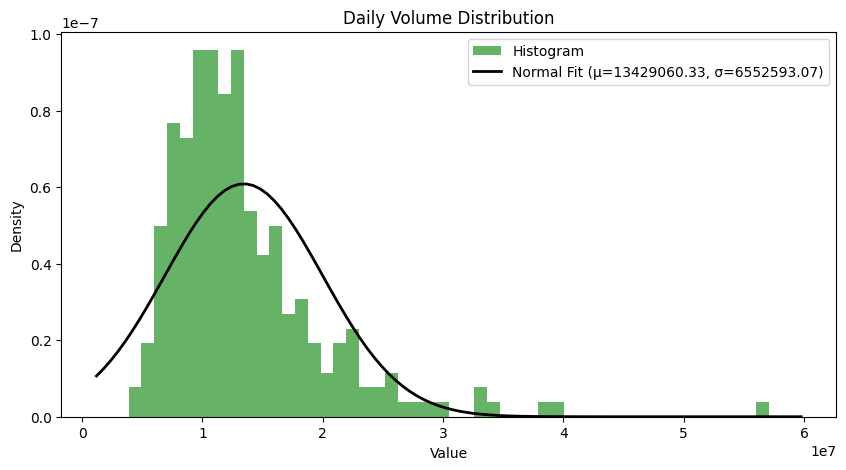

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


Close Price Analysis :
Mean: 1165.02, T-Statistic: 1.97, Confidence Interval: (Ticker
RELIANCE.NS    1156.376869
dtype: float64, Ticker
RELIANCE.NS    1173.653396
dtype: float64)


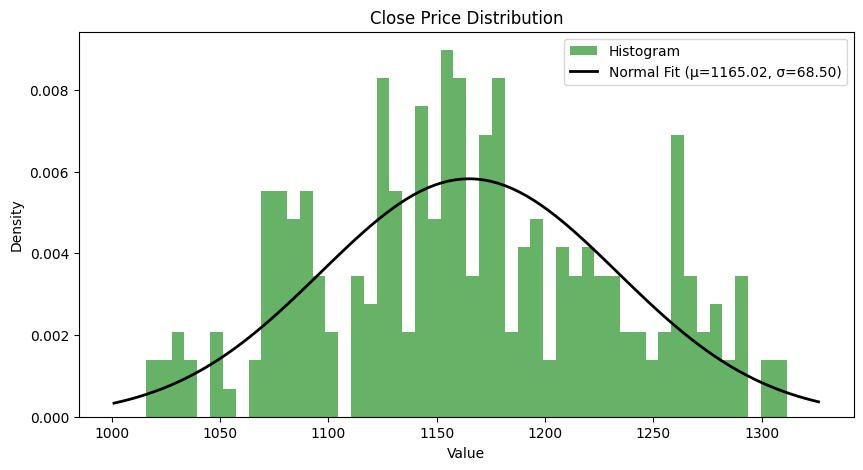


Daily Return Analysis for RELIANCE.NS:
Mean: 0.0004, T-Statistic: 1.97, Confidence Interval: (-0.0009830712527344907, 0.0017885961196136449)


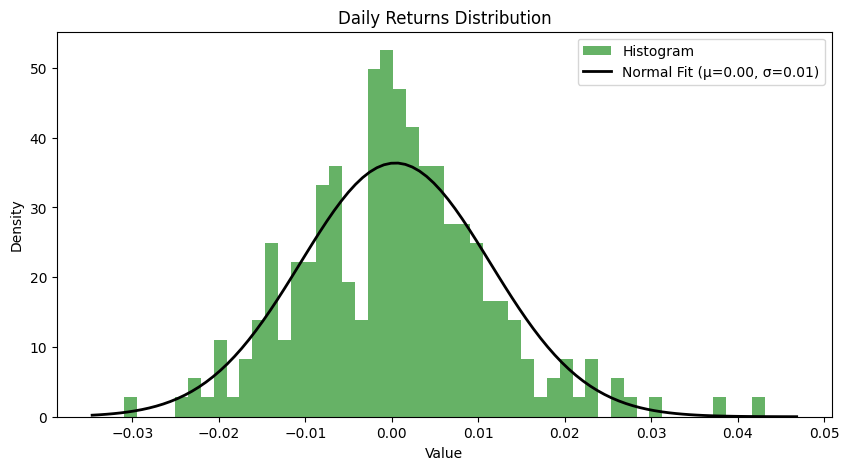

In [10]:
def df(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Daily Return'] = data['Close'].pct_change()
    return data

def z_score(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data-mean)/std_dev
    return z_scores

def t_score(data, confidence=0.95):
    mean = np.mean(data)
    std_error = np.std(data,ddof=1)/np.sqrt(len(data))
    t_stat = t.ppf((1 + confidence)/2,df=len(data)-1)
    ci_lower = mean-t_stat*std_error
    ci_upper = mean+t_stat*std_error
    return mean, t_stat, (ci_lower, ci_upper)

def plot_probability_distribution(data, title):
    plt.figure(figsize=(10, 5))
    plt.hist(data, bins=50, alpha=0.6, color='green', density=True, label='Histogram')
    mu, std = norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2, label=f'Normal Fit (μ={mu:.2f}, σ={std:.2f})')
    plt.title(title)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

ticker = "RELIANCE.NS"
start_date = "2023-01-01"
end_date = "2024-01-01"

data=df(ticker, start_date, end_date)

volume_data = data['Volume'].dropna()
volume_z_scores = z_score(volume_data)
volume_mean, volume_t_stat, volume_ci = t_score(volume_data)
print("Volume Analysis")
print(f"Mean: {volume_mean:.2f}, T-Statistic: {volume_t_stat:.2f}, Confidence Interval: {volume_ci}")
plot_probability_distribution(volume_data,"Daily Volume Distribution")

close_data = data['Close'].dropna()
close_z_scores = z_score(close_data)
close_mean, close_t_stat, close_ci = t_score(close_data)
print("Close Price Analysis :")
print(f"Mean: {close_mean:.2f}, T-Statistic: {close_t_stat:.2f}, Confidence Interval: {close_ci}")
plot_probability_distribution(close_data, "Close Price Distribution")

returns_data = data['Daily Return'].dropna()
returns_z_scores = z_score(returns_data)
returns_mean, returns_t_stat, returns_ci = t_score(returns_data)
print(f"\nDaily Return Analysis for {ticker}:")
print(f"Mean: {returns_mean:.4f}, T-Statistic: {returns_t_stat:.2f}, Confidence Interval: {returns_ci}")
plot_probability_distribution(returns_data,"Daily Returns Distribution")

# **BONUS**

In [39]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.5:
        print("Non-stationary")
    else:
        print("Stationary")
    return result[1]

def kpss_test(series):
    result = kpss(series, regression='c', nlags="auto")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("Non-stationary")
    else:
        print("Stationary)")
    return result[1]

def analyze_stationary(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    close_prices = data['Close'].dropna()
    print(f"\nADF Test for {ticker} Close Prices:")
    adf_pvalue = adf_test(close_prices)

    print(f"\nKPSS Test for {ticker} Close Prices:")
    kpss_pvalue = kpss_test(close_prices)

    if adf_pvalue > 0.5 and kpss_pvalue < 0.5:
        print(f"\nConclusion: {ticker} is Non-Stationary.")
        sns='Non-Stationary'
    else:
        print(f"\nConclusion: {ticker} is Stationary.")
        sns='Stationary'
    return sns

start_date = "2023-04-01"
end_date = "2024-03-31"
stocks = ["3MINDIA.NS", "TCS.NS", "GOOGL"]
company=[]
sns=[]
for stock in ticker_list:
    company.append(stock)
    sns.append(analyze_stationary(stock, start_date, end_date))
    print("-" * 50)
datas=pd.DataFrame(columns=['Company','Stationary/Non-Stationary'])
datas['Company']=company
datas['Stationary/Non-Stationary']=sns
datas

[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************


ADF Test for RELIANCE.NS Close Prices:
ADF Statistic: -0.46069349287642963
p-value: 0.8994613648207985
Non-stationary

KPSS Test for RELIANCE.NS Close Prices:
KPSS Statistic: 1.5217413550599566
p-value: 0.01
Non-stationary

Conclusion: RELIANCE.NS is Non-Stationary.
--------------------------------------------------

ADF Test for TCS.NS Close Prices:
ADF Statistic: -1.1950355906954708
p-value: 0.6757276211881381
Non-stationary

KPSS Test for TCS.NS Close Prices:
KPSS Statistic: 1.9443203074435733
p-value: 0.01
Non-stationary

Conclusion: TCS.NS is Non-Stationary.
--------------------------------------------------

ADF Test for HDFCBANK.NS Close Prices:
ADF Statistic: -1.3598404986267982
p-value: 0.6013705870726134
Non-stationary

KPSS Test for HDFCBANK.NS Close Prices:
KPSS Statistic: 1.174379888253074
p-value: 0.01
Non-stationary

Conclusion: HDFCBANK.NS is Non-Stationary.
--------------------------------------------------

ADF Test for BHARTIARTL.NS Close Prices:


<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed


ADF Statistic: 0.310669784550637
p-value: 0.9778287486397828
Non-stationary

KPSS Test for BHARTIARTL.NS Close Prices:
KPSS Statistic: 2.147288575688098
p-value: 0.01
Non-stationary

Conclusion: BHARTIARTL.NS is Non-Stationary.
--------------------------------------------------

ADF Test for ICICIBANK.NS Close Prices:
ADF Statistic: -1.0239585606433212
p-value: 0.7444259864635245
Non-stationary

KPSS Test for ICICIBANK.NS Close Prices:
KPSS Statistic: 1.4930850771111417
p-value: 0.01
Non-stationary

Conclusion: ICICIBANK.NS is Non-Stationary.
--------------------------------------------------

ADF Test for INFY.NS Close Prices:
ADF Statistic: -1.3297267720317223
p-value: 0.6154649560756236
Non-stationary

KPSS Test for INFY.NS Close Prices:
KPSS Statistic: 1.8641289392809761
p-value: 0.01
Non-stationary

Conclusion: INFY.NS is Non-Stationary.
--------------------------------------------------

ADF Test for SBIN.NS Close Prices:
ADF Statistic: -0.4322557616198178
p-value: 0.904572325557

<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c


ADF Test for ITC.NS Close Prices:
ADF Statistic: -2.976172400414764
p-value: 0.0371803127890374
Stationary

KPSS Test for ITC.NS Close Prices:
KPSS Statistic: 0.2764009202418296
p-value: 0.1
Stationary)

Conclusion: ITC.NS is Stationary.
--------------------------------------------------

ADF Test for HINDUNILVR.NS Close Prices:
ADF Statistic: -0.75323360856287
p-value: 0.8324750037759534
Non-stationary

KPSS Test for HINDUNILVR.NS Close Prices:
KPSS Statistic: 1.1800016824707036
p-value: 0.01
Non-stationary

Conclusion: HINDUNILVR.NS is Non-Stationary.
--------------------------------------------------

ADF Test for LT.NS Close Prices:
ADF Statistic: -0.33744160195065853
p-value: 0.9200315368664944
Non-stationary

KPSS Test for LT.NS Close Prices:
KPSS Statistic: 2.2493807598145876
p-value: 0.01
Non-stationary

Conclusion: LT.NS is Non-Stationary.
--------------------------------------------------



<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed


ADF Test for HCLTECH.NS Close Prices:
ADF Statistic: -0.572423854646107
p-value: 0.8770921590523203
Non-stationary

KPSS Test for HCLTECH.NS Close Prices:
KPSS Statistic: 2.0913348090777
p-value: 0.01
Non-stationary

Conclusion: HCLTECH.NS is Non-Stationary.
--------------------------------------------------

ADF Test for BAJFINANCE.NS Close Prices:
ADF Statistic: -2.719978670672275
p-value: 0.07064443193748035
Stationary

KPSS Test for BAJFINANCE.NS Close Prices:
KPSS Statistic: 0.4867707817059564
p-value: 0.04464622033649631
Non-stationary

Conclusion: BAJFINANCE.NS is Stationary.
--------------------------------------------------

ADF Test for SUNPHARMA.NS Close Prices:
ADF Statistic: 1.6680898768799934
p-value: 0.998048131049826
Non-stationary

KPSS Test for SUNPHARMA.NS Close Prices:
KPSS Statistic: 2.0071780535653625
p-value: 0.01
Non-stationary

Conclusion: SUNPHARMA.NS is Non-Stationary.
--------------------------------------------------



<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed


ADF Test for M&M.NS Close Prices:
ADF Statistic: -1.0720437687523028
p-value: 0.7260908204462868
Non-stationary

KPSS Test for M&M.NS Close Prices:
KPSS Statistic: 1.9302330654242426
p-value: 0.01
Non-stationary

Conclusion: M&M.NS is Non-Stationary.
--------------------------------------------------

ADF Test for KOTAKBANK.NS Close Prices:
ADF Statistic: -2.307057823062936
p-value: 0.1697017862707138
Stationary

KPSS Test for KOTAKBANK.NS Close Prices:
KPSS Statistic: 1.097679639111946
p-value: 0.01
Non-stationary

Conclusion: KOTAKBANK.NS is Stationary.
--------------------------------------------------

ADF Test for AXISBANK.NS Close Prices:
ADF Statistic: -1.9061960131629656
p-value: 0.32915194826455463
Stationary

KPSS Test for AXISBANK.NS Close Prices:
KPSS Statistic: 1.9449393683492724
p-value: 0.01
Non-stationary

Conclusion: AXISBANK.NS is Stationary.
--------------------------------------------------



<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed



ADF Test for MARUTI.NS Close Prices:
ADF Statistic: 0.14084106277701508
p-value: 0.9687413934601559
Non-stationary

KPSS Test for MARUTI.NS Close Prices:
KPSS Statistic: 1.8301404396304113
p-value: 0.01
Non-stationary

Conclusion: MARUTI.NS is Non-Stationary.
--------------------------------------------------

ADF Test for ULTRACEMCO.NS Close Prices:
ADF Statistic: -0.861381771281219
p-value: 0.8004238796044587
Non-stationary

KPSS Test for ULTRACEMCO.NS Close Prices:
KPSS Statistic: 1.972170399831331
p-value: 0.01
Non-stationary

Conclusion: ULTRACEMCO.NS is Non-Stationary.
--------------------------------------------------

ADF Test for NTPC.NS Close Prices:
ADF Statistic: -0.6473664284057149
p-value: 0.8599160443374421
Non-stationary

KPSS Test for NTPC.NS Close Prices:
KPSS Statistic: 2.211474420266698
p-value: 0.01
Non-stationary

Conclusion: NTPC.NS is Non-Stationary.
--------------------------------------------------

ADF Test for WIPRO.NS Close Prices:


<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed

ADF Statistic: -1.211623073573181
p-value: 0.6685758804453268
Non-stationary

KPSS Test for WIPRO.NS Close Prices:
KPSS Statistic: 1.6394463888303885
p-value: 0.01
Non-stationary

Conclusion: WIPRO.NS is Non-Stationary.
--------------------------------------------------

ADF Test for ONGC.NS Close Prices:
ADF Statistic: -0.7027298648108458
p-value: 0.8460411736466851
Non-stationary

KPSS Test for ONGC.NS Close Prices:
KPSS Statistic: 1.9523520559003844
p-value: 0.01
Non-stationary

Conclusion: ONGC.NS is Non-Stationary.
--------------------------------------------------

ADF Test for TITAN.NS Close Prices:
ADF Statistic: -1.119480664125858
p-value: 0.7072410521414889
Non-stationary

KPSS Test for TITAN.NS Close Prices:
KPSS Statistic: 2.2063038032279025
p-value: 0.01
Non-stationary

Conclusion: TITAN.NS is Non-Stationary.
--------------------------------------------------



<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")



ADF Test for POWERGRID.NS Close Prices:
ADF Statistic: 0.17607221926163708
p-value: 0.9708871701563008
Non-stationary

KPSS Test for POWERGRID.NS Close Prices:
KPSS Statistic: 2.017414354566155
p-value: 0.01
Non-stationary

Conclusion: POWERGRID.NS is Non-Stationary.
--------------------------------------------------

ADF Test for ADANIENT.NS Close Prices:
ADF Statistic: -1.4996796970828117
p-value: 0.5336697822291919
Non-stationary

KPSS Test for ADANIENT.NS Close Prices:
KPSS Statistic: 1.683665501329136
p-value: 0.01
Non-stationary

Conclusion: ADANIENT.NS is Non-Stationary.
--------------------------------------------------

ADF Test for TATAMOTORS.NS Close Prices:
ADF Statistic: 0.12294583298791542
p-value: 0.9675932420909187
Non-stationary

KPSS Test for TATAMOTORS.NS Close Prices:
KPSS Statistic: 2.039267929269392
p-value: 0.01
Non-stationary

Conclusion: TATAMOTORS.NS is Non-Stationary.
--------------------------------------------------


[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************


ADF Test for ADANIPORTS.NS Close Prices:
ADF Statistic: 0.6890183322938915
p-value: 0.9896161442864778
Non-stationary

KPSS Test for ADANIPORTS.NS Close Prices:
KPSS Statistic: 1.9661806149751082
p-value: 0.01
Non-stationary

Conclusion: ADANIPORTS.NS is Non-Stationary.
--------------------------------------------------

ADF Test for BAJAJFINSV.NS Close Prices:
ADF Statistic: -2.585779160761354
p-value: 0.09597219007880153
Stationary

KPSS Test for BAJAJFINSV.NS Close Prices:
KPSS Statistic: 1.465938212128531
p-value: 0.01
Non-stationary

Conclusion: BAJAJFINSV.NS is Stationary.
--------------------------------------------------

ADF Test for COALINDIA.NS Close Prices:
ADF Statistic: -0.09220221536543231
p-value: 0.950209705468795
Non-stationary

KPSS Test for COALINDIA.NS Close Prices:
KPSS Statistic: 2.1329023120088126
p-value: 0.01
Non-stationary

Conclusion: COALINDIA.NS is Non-Stationary.
--------------------------------------------------

ADF Test for BAJAJ-AUTO.NS Close Prices:

[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resul


ADF Test for TRENT.NS Close Prices:
ADF Statistic: 0.8572186582346143
p-value: 0.9925058323594124
Non-stationary

KPSS Test for TRENT.NS Close Prices:
KPSS Statistic: 2.1387564675739212
p-value: 0.01
Non-stationary

Conclusion: TRENT.NS is Non-Stationary.
--------------------------------------------------

ADF Test for JSWSTEEL.NS Close Prices:
ADF Statistic: -2.378959207973108
p-value: 0.14776328716831172
Stationary

KPSS Test for JSWSTEEL.NS Close Prices:
KPSS Statistic: 1.3150844262607593
p-value: 0.01
Non-stationary

Conclusion: JSWSTEEL.NS is Stationary.
--------------------------------------------------

ADF Test for ASIANPAINT.NS Close Prices:
ADF Statistic: -1.7821679518219804
p-value: 0.3893500548834704
Stationary

KPSS Test for ASIANPAINT.NS Close Prices:
KPSS Statistic: 0.41310250861289705
p-value: 0.07150753939099266
Stationary)

Conclusion: ASIANPAINT.NS is Stationary.
--------------------------------------------------

ADF Test for BEL.NS Close Prices:
ADF Statistic: -0.

<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c


ADF Test for NESTLEIND.NS Close Prices:
ADF Statistic: -1.5602587136125057
p-value: 0.5035199405048719
Non-stationary

KPSS Test for NESTLEIND.NS Close Prices:
KPSS Statistic: 2.030340188501396
p-value: 0.01
Non-stationary

Conclusion: NESTLEIND.NS is Non-Stationary.
--------------------------------------------------

ADF Test for TATASTEEL.NS Close Prices:
ADF Statistic: -0.48710420940034116
p-value: 0.894508551036058
Non-stationary

KPSS Test for TATASTEEL.NS Close Prices:
KPSS Statistic: 2.1052335901865478
p-value: 0.01
Non-stationary

Conclusion: TATASTEEL.NS is Non-Stationary.
--------------------------------------------------

ADF Test for GRASIM.NS Close Prices:
ADF Statistic: -0.002513535003989109
p-value: 0.9583237241967784
Non-stationary

KPSS Test for GRASIM.NS Close Prices:
KPSS Statistic: 2.2399076329713403
p-value: 0.01
Non-stationary

Conclusion: GRASIM.NS is Non-Stationary.
--------------------------------------------------

ADF Test for TECHM.NS Close Prices:
ADF Stat

<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************

ADF Statistic: -1.2804442217749832
p-value: 0.6380709452562772
Non-stationary

KPSS Test for HINDALCO.NS Close Prices:
KPSS Statistic: 1.9646165799908475
p-value: 0.01
Non-stationary

Conclusion: HINDALCO.NS is Non-Stationary.
--------------------------------------------------

ADF Test for SBILIFE.NS Close Prices:
ADF Statistic: -1.551928640314572
p-value: 0.5076846734132909
Non-stationary

KPSS Test for SBILIFE.NS Close Prices:
KPSS Statistic: 2.101348323726398
p-value: 0.01
Non-stationary

Conclusion: SBILIFE.NS is Non-Stationary.
--------------------------------------------------

ADF Test for HDFCLIFE.NS Close Prices:
ADF Statistic: -2.7409261805171377
p-value: 0.06722002423286386
Stationary

KPSS Test for HDFCLIFE.NS Close Prices:
KPSS Statistic: 0.5950604233149471
p-value: 0.02308541606227753
Non-stationary

Conclusion: HDFCLIFE.NS is Stationary.
--------------------------------------------------

ADF Test for EICHERMOT.NS Close Prices:
ADF Statistic: -2.0042906720957245
p-value


<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed


ADF Test for BPCL.NS Close Prices:
ADF Statistic: -0.06853326684606766
p-value: 0.9524839388589658
Non-stationary

KPSS Test for BPCL.NS Close Prices:
KPSS Statistic: 1.6037102325133592
p-value: 0.01
Non-stationary

Conclusion: BPCL.NS is Non-Stationary.
--------------------------------------------------

ADF Test for SHRIRAMFIN.NS Close Prices:
ADF Statistic: -1.1406980494662229
p-value: 0.6985722506447725
Non-stationary

KPSS Test for SHRIRAMFIN.NS Close Prices:
KPSS Statistic: 2.120738069890754
p-value: 0.01
Non-stationary

Conclusion: SHRIRAMFIN.NS is Non-Stationary.
--------------------------------------------------

ADF Test for CIPLA.NS Close Prices:
ADF Statistic: -0.4325125078548386
p-value: 0.9045271934217305
Non-stationary

KPSS Test for CIPLA.NS Close Prices:
KPSS Statistic: 2.0383837950667387
p-value: 0.01
Non-stationary

Conclusion: CIPLA.NS is Non-Stationary.
--------------------------------------------------

ADF Test for BRITANNIA.NS Close Prices:



[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed
<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[********************

ADF Statistic: -2.016461917230344
p-value: 0.27940209239495817
Stationary

KPSS Test for BRITANNIA.NS Close Prices:
KPSS Statistic: 0.7238465457308105
p-value: 0.011377586751744497
Non-stationary

Conclusion: BRITANNIA.NS is Stationary.
--------------------------------------------------

ADF Test for APOLLOHOSP.NS Close Prices:
ADF Statistic: -0.9547584076380068
p-value: 0.7694056188940701
Non-stationary

KPSS Test for APOLLOHOSP.NS Close Prices:
KPSS Statistic: 1.8874632716032926
p-value: 0.01
Non-stationary

Conclusion: APOLLOHOSP.NS is Non-Stationary.
--------------------------------------------------

ADF Test for DRREDDY.NS Close Prices:
ADF Statistic: -1.2794199289979626
p-value: 0.6385343449170349
Non-stationary

KPSS Test for DRREDDY.NS Close Prices:
KPSS Statistic: 1.795908521172114
p-value: 0.01
Non-stationary

Conclusion: DRREDDY.NS is Non-Stationary.
--------------------------------------------------

ADF Test for TATACONSUM.NS Close Prices:
ADF Statistic: -1.19528245945108

<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")
[*********************100%***********************]  1 of 1 completed




KPSS Test for HEROMOTOCO.NS Close Prices:
KPSS Statistic: 2.025160981791402
p-value: 0.01
Non-stationary

Conclusion: HEROMOTOCO.NS is Non-Stationary.
--------------------------------------------------

ADF Test for INDUSINDBK.NS Close Prices:
ADF Statistic: -2.2580906471411
p-value: 0.18584087319188947
Stationary

KPSS Test for INDUSINDBK.NS Close Prices:
KPSS Statistic: 1.878419824769266
p-value: 0.01
Non-stationary

Conclusion: INDUSINDBK.NS is Stationary.
--------------------------------------------------


<ipython-input-39-9b3c8a316f09>:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series, regression='c', nlags="auto")


,Company,Stationary/Non-Stationary
0,RELIANCE.NS,Non-Stationary
1,TCS.NS,Non-Stationary
2,HDFCBANK.NS,Non-Stationary
3,BHARTIARTL.NS,Non-Stationary
4,ICICIBANK.NS,Non-Stationary
5,INFY.NS,Non-Stationary
6,SBIN.NS,Non-Stationary
7,ITC.NS,Stationary
8,HINDUNILVR.NS,Non-Stationary
9,LT.NS,Non-Stationary
